In [1]:
# Carrie Lei & Diana Cantini
# Final Project: Phased Array Antenna Simulation

dipole at  143  ,  147
dipole at  144  ,  147
dipole at  145  ,  147
dipole at  146  ,  147
dipole at  147  ,  147
dipole at  148  ,  147
free space at  149 147
center at  150 147
free space at  151 147
dipole at  152  ,  147
dipole at  153  ,  147
dipole at  154  ,  147
dipole at  155  ,  147
dipole at  156  ,  147
dipole at  157  ,  147
dipole at  143  ,  152
dipole at  144  ,  152
dipole at  145  ,  152
dipole at  146  ,  152
dipole at  147  ,  152
dipole at  148  ,  152
free space at  149 152
center at  150 152
free space at  151 152
dipole at  152  ,  152
dipole at  153  ,  152
dipole at  154  ,  152
dipole at  155  ,  152
dipole at  156  ,  152
dipole at  157  ,  152
sources  [(147, 150), (152, 150)]


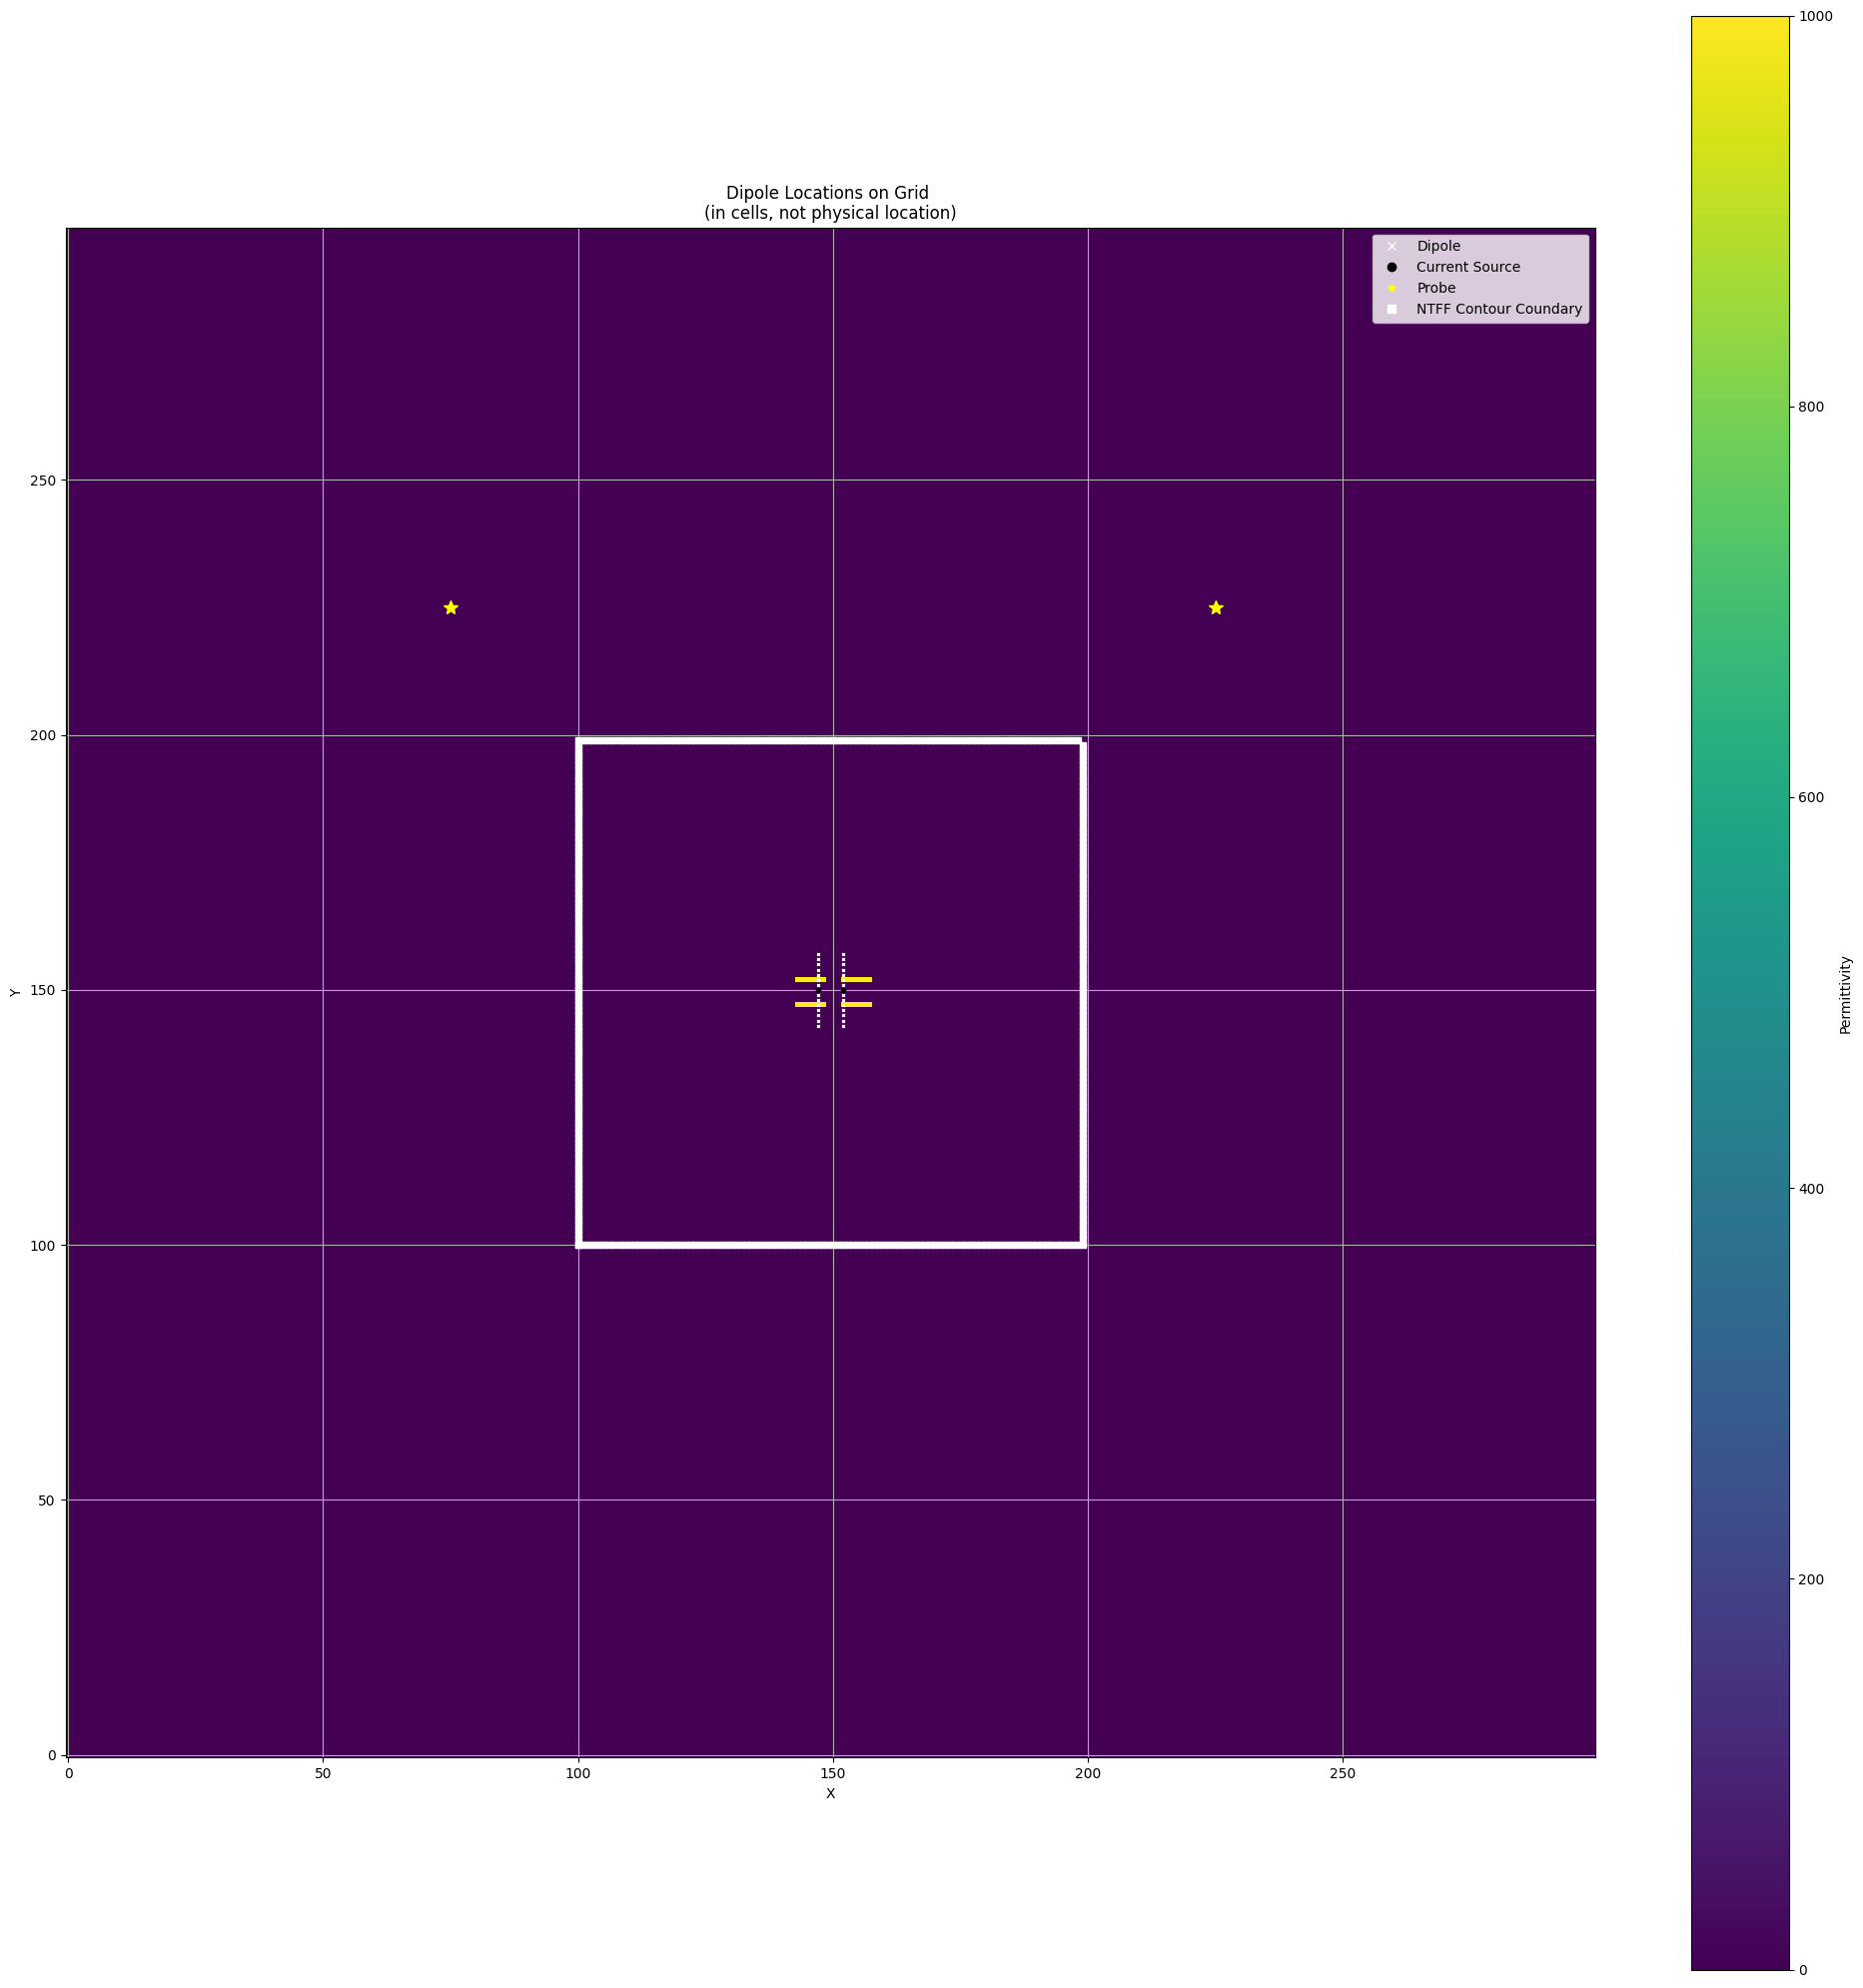

In [55]:
# streamlined function to simulate 1xn antennas

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

# Simulation Parameters

e0 = 1        
mu0 = 1       
c0 = 1 #1 / math.sqrt(e0 * mu0) 
'''
e0 = 8.85e-12
mu0 = np.pi*4e-7
c0 = 1 / math.sqrt(e0 * mu0) 
'''

#We want 20 cells per wavelength.
#Since we are using 0.5mm for cell dimensions,
#20 * 0.5mm = 10mm wavelength
#With normalized c = 1, f = 1/0.01 = 100Hz
dx = 0.5e-3 # unit cell is 0.5mm x 0.5mm
dy = 0.5e-3 
magic_time_step = dx / (np.sqrt(2) * c0)
max_time_steps = 310
f0 = 5e9

# Grid in cell units
#whole_grid = 200e-3 # whole grid = 200 mm

#EDIT
whole_grid = 150e-3 # whole grid = 200 mm

numX_cells = int(whole_grid / dx)  
numY_cells = int(whole_grid / dy)   
center_x = numX_cells // 2 # find center points
center_y = numY_cells // 2

# Set up the permittivity grid 
grid = np.ones((numY_cells, numX_cells)) * e0

# Source parameters
f0=100
lambda0 = c0/f0 # wavelength for 5G is 6 cm
#EDIT: change lambda0 to reflect normalized condition
#lambda0 = 60e-3
lambda_lower = c0 / 4.5e-9
lambda_upper = c0 / 5.5e-9
omega0 = 2 * np.pi * c0 / lambda0
sigma = (2 / omega0) * (lambda0 / (lambda_upper - lambda_lower))


# Dipole Parameters
#EDIT PARAMETERS
numberAntennas = 2
dipole_epsilon = 1000
epsilon_dipole_center=0
#dipole_spacing_cells = int(.03 / dx) # space between dipoles = lambda/2 = 30mm
#EDIT: lambda / 4 spacing
lambda_by_4 = lambda0 / 4
dipole_spacing_cells = int(lambda_by_4 / dx) # space between dipoles = 15mm = 30 cells

dipole_width = 1e-3 # dipole thickness = 1 mm
#dipole_height = 15e-3 # dipole height = 15 mm
#Edit: total height should be 30mm ,each arm is quarter wavelength

dipole_height = 2 * lambda_by_4 #30e-3 # dipole height = 15 mm
dipole_width_cells = int(dipole_width / dx)         
dipole_height_cells = int(dipole_height / dy)  

# Probe locations
probe_beam_direction_x = int(numX_cells *.75) # this probe is put at the angle of target beam (45 degrees from x axis)
probe_beam_direction_y = int(numY_cells * .75)
probe_x = int(numX_cells * .25) # this probe is put far away from target angle (135 from x axis)
probe_y = int(numY_cells *.75)
Ez_probe_beam = np.zeros(max_time_steps) # store values at probes
Ez_probe = np.zeros(max_time_steps)

# NTFF Parameters ----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Compute phasor E and M fields on closed contour boundary
# defining square boundary form L1 --> L4
line_size = whole_grid - 100e-3 # lines form a boundary 50mm inside of whole grid size
numL_cells = int(line_size // dx) #numL cells is length of closed countour boundary in cell units

L_starting_dim= 50e-3 #starting index for L2, L4
L_starting_cell_idx = int(L_starting_dim //dx)
L_ending_dim= numX_cells - numL_cells
L_ending_cell_idx=L_starting_cell_idx + numL_cells

#L1 is vertical, RHS line
L1_col1 = np.full(numL_cells, L_ending_cell_idx)
L1_col2=np.arange(L_starting_cell_idx, L_ending_cell_idx)

L1_idxs = np.column_stack((L1_col1,L1_col2))

#L2 is vertical, LHS line
L2_col1=np.full(numL_cells,L_starting_cell_idx)
L2_col2=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L2_idxs=np.column_stack((L2_col1,L2_col2))

#L3 is horizontal, top line
L3_col1=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L3_col2=np.full(numL_cells, L_ending_cell_idx)
L3_idxs=np.column_stack((L3_col1,L3_col2))

#L4 is horizontal, bottom line
L4_col1=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L4_col2=np.full(numL_cells, L_starting_cell_idx)
L4_idxs=np.column_stack((L4_col1,L4_col2))

#print(L1_idxs)
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Current source vectors
sources = []

# Beam steering parameters
angle_target = 30
angle_target_rad = np.deg2rad(angle_target)
# k0 = 2 * np.pi / lambda0



def placeAndVisualizeAntennas(numAntennas, spacingBetween, dipoleLength, dipoleWidth, grid, e_dipole):

    # find where the centers of each dipole would be
    centers = []

    if (numAntennas %2) == 1: # for odd number of antennas, the middle one is at center of grid
        for i in range(numAntennas):
            leftPoint = center_x - (numAntennas //2) *spacingBetween
            centers.append(leftPoint + (i*spacingBetween))

    else: # for an even number of antennas, the middle point of grid is between two antennas
        spaceFromCenter = spacingBetween // 2
        for i in range(numAntennas):
            leftPoint = center_x - (numAntennas //2 -1) *spacingBetween - spaceFromCenter
            centers.append(leftPoint + (i*spacingBetween))

    # Visualize everything
    plt.figure(figsize=(20, 20))

    # Find dimensions of antenna on the grid
    for x in centers:
        x_center = x
        x_left = x_center - (dipoleWidth // 2)
        x_right = x_left + dipoleWidth - 1
        x_bottom = center_y - (dipoleLength // 2)
        x_top = x_bottom + dipoleLength - 1

        # place antennas on permittivity grid
        for y in range(x_left, x_right ):#+ 1):
            for z in range(x_bottom-2, x_top + 4):
                if(z==center_y):
                    print('center at ',z,y)
                    grid[y,z] = epsilon_dipole_center
                elif(z==center_y+1 or z==center_y-1):
                    print('free space at ',z,y)
                    grid[y,z] = 2
                else:
                    grid[y,z] = dipole_epsilon
                    print('dipole at ',z,' , ',y)
                plt.plot(y, z, 'x', markersize = 2, color='white')

        sources.append((x-1, center_y))
    
    # Show where the sources are injected on grid
    print('sources ',sources)
    for location in sources:
        plt.plot(location[0], location[1], 'o', markersize = 3, color = 'black')
    
    # Show where the probes are on the grid
    plt.plot(probe_beam_direction_x, probe_beam_direction_y, '*', markersize = 10, color = 'yellow')
    plt.plot(probe_x, probe_y, '*', markersize = 10, color = 'yellow')

    #Adding (x,y) pairs from L1, shown as white
    all_line_idx=[L1_idxs,L2_idxs,L3_idxs,L4_idxs]
    for j in all_line_idx:
        for x, y in j:
            plt.plot(x,y, 's',markersize = 4, color = 'white')
    
    # Plot the permittivity grid
    plt.imshow(grid, cmap='viridis', origin= 'lower')
    plt.colorbar(label='Permittivity')

    # Add the legend
    plt.plot([], [], 'x', color = 'white', label = 'Dipole')
    plt.plot([], [], 'o', color = 'black', label = 'Current Source')
    plt.plot([], [], '*', color = 'yellow', label = 'Probe')
    plt.plot([], [], 's', color ='white', label = 'NTFF Contour Coundary')
    plt.legend(loc='upper right', fontsize = 'medium')

    plt.title('Dipole Locations on Grid \n(in cells, not physical location)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    plt.grid()
    plt.show()

placeAndVisualizeAntennas(numberAntennas, dipole_spacing_cells, dipole_height_cells, dipole_width_cells, grid, dipole_epsilon)
#np.set_printoptions(threshold=np.inf, linewidth=np.inf, suppress=True)

#print(grid)

In [56]:
# Calculate phase shifts for each antenna element
k0 = 2*np.pi/lambda0
for idx, (x_coord, y_coord) in enumerate(sources):
    phase = 3e8*-k0*dipole_spacing_cells*dx * idx * np.cos(angle_target_rad)
    print(x_coord, y_coord, phase)

147 150 -0.0
152 150 -408104856.95269907


In [77]:
# Defining Ez_time_L1 (right hand side line)
Ez_time_L1 = np.zeros((numL_cells, max_time_steps))
Hx_time_L1 = np.zeros((numL_cells, max_time_steps))
Hy_time_L1 = np.zeros((numL_cells, max_time_steps))
Hx_time_L1_minus = np.zeros((numL_cells, max_time_steps))
Hy_time_L1_minus = np.zeros((numL_cells, max_time_steps))
# defining L2
Ez_time_L2 = np.zeros((numL_cells, max_time_steps))
Hx_time_L2 = np.zeros((numL_cells, max_time_steps))
Hy_time_L2 = np.zeros((numL_cells, max_time_steps))
Hx_time_L2_minus = np.zeros((numL_cells, max_time_steps))
Hy_time_L2_minus = np.zeros((numL_cells, max_time_steps))

# defining L3
Ez_time_L3 = np.zeros((numL_cells, max_time_steps))
Hx_time_L3 = np.zeros((numL_cells, max_time_steps))
Hy_time_L3 = np.zeros((numL_cells, max_time_steps))
Hx_time_L3_minus = np.zeros((numL_cells, max_time_steps))
Hy_time_L3_minus = np.zeros((numL_cells, max_time_steps))

# defining L4
Ez_time_L4 = np.zeros((numL_cells, max_time_steps))
Hx_time_L4 = np.zeros((numL_cells, max_time_steps))
Hy_time_L4 = np.zeros((numL_cells, max_time_steps))
Hx_time_L4_minus = np.zeros((numL_cells, max_time_steps))
Hy_time_L4_minus = np.zeros((numL_cells, max_time_steps))

# combining into more streamlined list so can process easier later
L_idxs_list = [L1_idxs, L2_idxs, L3_idxs, L4_idxs]
Ez_time_list = [Ez_time_L1, Ez_time_L2, Ez_time_L3, Ez_time_L4]
Hx_time_list = [Hx_time_L1, Hx_time_L2, Hx_time_L3, Hx_time_L4]
Hx_time_minus=[Hx_time_L1_minus,Hx_time_L2_minus,Hx_time_L3_minus,Hy_time_L4_minus]
Hy_time_list = [Hy_time_L1, Hy_time_L2, Hy_time_L3, Hy_time_L4]
Hy_time_minus=[Hy_time_L1_minus,Hy_time_L2_minus,Hy_time_L3_minus,Hy_time_L4_minus]

NTFF_lines = []
for Ez_time, Hx_time, Hx_time_minus,Hy_time, Hy_time_minus,idxs in zip(Ez_time_list, Hx_time_list, Hx_time_minus,Hy_time_list, Hy_time_minus,L_idxs_list):
    mask = np.zeros((numX_cells, numY_cells), dtype=bool)
    index_map = -np.ones((numX_cells, numY_cells), dtype=int)
    
    for idx, (x, y) in enumerate(idxs):
        mask[x, y] = True
        index_map[x, y] = idx
    
    NTFF_lines.append({"Ez": Ez_time, "Hx": Hx_time, "Hx_minus":Hx_time_minus,"Hy": Hy_time, "Hy_minus" : Hy_time_minus,"mask": mask, "index": index_map})

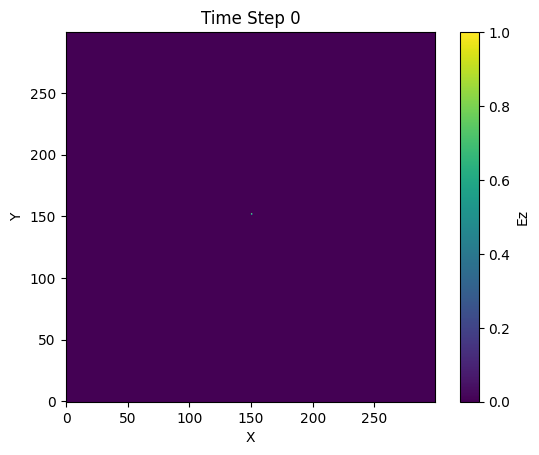

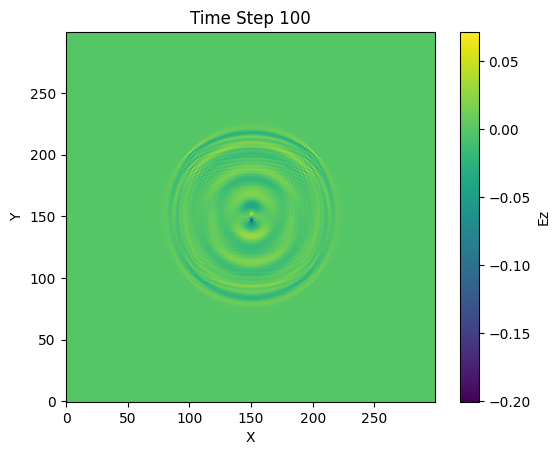

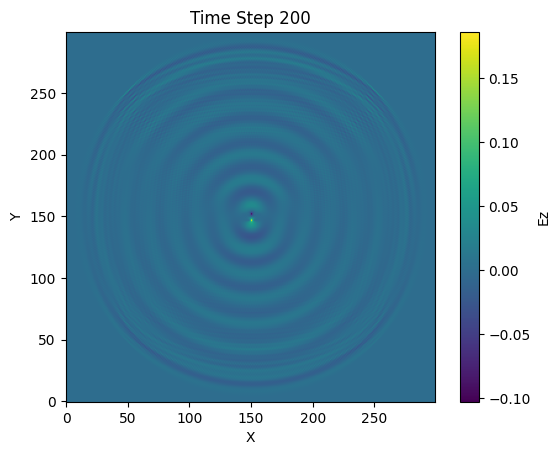

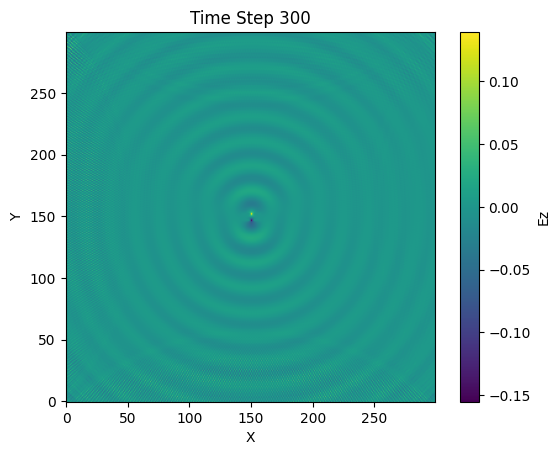

In [80]:
# Main 2D FDTD Loop
# Arrays to store fields
# Store Ez Frames
Ez_frames = []

Ez = np.zeros((numX_cells, numY_cells))
Hx = np.zeros((numX_cells, numY_cells))
Hy = np.zeros((numX_cells, numY_cells))

#Initializing very first boundaries
boundaryLeft = 0
boundaryBottom = 0
boundaryRight = 0
boundaryTop = 0
    
for n in range(max_time_steps):
    
    # Compute Hy 
    for i in range(numX_cells - 1):
        for j in range(numY_cells):
            Hy[i, j] += (Ez[i + 1, j] - Ez[i, j]) * magic_time_step / dx
            
            for line in NTFF_lines:
                if line["mask"][i, j]:
                    idx = line["index"][i, j]
                    line["Hy"][idx, n] = 0.5 * (Hy[i, j] + Hy[i - 1, j])  # collocation
                    
                    #line["Hy"][idx, n] = Hy[i, j]
                    #line["Hy_minus"][idx,n]=Hy[i-1,j]
            
    # Compute Hx
    for i in range(numX_cells):
        for j in range(numY_cells - 1):
            Hx[i, j] -= (Ez[i, j + 1] - Ez[i, j]) * magic_time_step / dy
            
            for line in NTFF_lines:
                if line["mask"][i, j]:
                    idx = line["index"][i, j]
                    line["Hx"][idx, n] = 0.5 * (Hx[i, j] + Hx[i, j - 1])  # collocation
                    #line["Hx"][idx, n] = Hx[i, j]
              
                    #line["Hx_minus"][idx,n]=Hx[i,j-1]
            

    # Use temp variables to store left and bottom Ez values sorta like a moving window; only 2 sides needed bc symmetrical
    tempLeft = Ez[1, :].copy() 
    tempBottom = Ez[:, 1].copy()  
    # Apply excitation at antenna sources
    #EDIT moved to be above Ez
    
     # Compute Ez ---------------------------------------------------------------------------- Wouldn't we have to update Ez_time_L1 using the Hx and Hy_time_l1 variables?
    for i in range(1, numX_cells - 1):
        for j in range(1, numY_cells - 1):

            #Checking if index is dipole
            if( grid[i,j]==dipole_epsilon ):#or grid[i,j]==2):
                Ez[i,j]=0
            
            else:
                Ez[i, j] += ((Hy[i, j] - Hy[i - 1, j]) * magic_time_step / dx) - ((Hx[i, j] - Hx[i, j - 1]) * magic_time_step / dy)
            
            #recording Ez at Lines
            
            for line in NTFF_lines:
                if line["mask"][i, j]:
                    idx = line["index"][i, j]
                    line["Ez"][idx, n] = Ez[i, j]
            
            #set Ez along dipole
    t_n = n * magic_time_step
    for idx, (x_coord, y_coord) in enumerate(sources):
        #phase = -k0*dipole_spacing_cells*dx * idx * np.cos(angle_target_rad)
        # Ez[x_coord, y_coord] += np.exp(-((t_n - 4 * sigma) ** 2) / sigma ** 2) * np.sin(omega0 * t_n + phase)
        #Hard set phase to zero
        phase=idx*np.pi/2
        Ez[x_coord, y_coord] += np.sin(omega0 * t_n + phase)
   
    # Store Ez at probes
    Ez_probe_beam[n] = np.abs(Ez[probe_beam_direction_x, probe_beam_direction_y])
    Ez_probe[n] = np.abs(Ez[probe_x, probe_y])

   

    # Update absorbing conditions
    Ez[0, :] = boundaryLeft
    Ez[-1, :] = boundaryRight
    Ez[:, 0] = boundaryBottom
    Ez[:, -1] = boundaryTop

    # Update boundary buffers for next time step
    boundaryLeft = tempLeft
    boundaryBottom = tempBottom
    boundaryRight = Ez[-2, :].copy()
    boundaryTop = Ez[:, -2].copy()
    
    # Visualize Ez field every 50 time steps
    if n % 100 == 0:
        plt.clf() 
        plt.imshow(Ez, cmap='viridis', origin='lower')
        plt.title(f"Time Step {n}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.colorbar(label="Ez")
        plt.pause(0.01) 
        plt.show()
    
    # Create Ez animation using frames at every 10 time steps 
    if n % 10 == 0:
        Ez_frames.append(Ez.copy())


KeyboardInterrupt: 

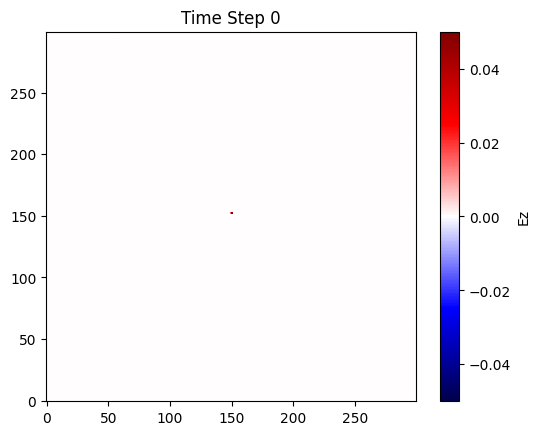

In [81]:
# Create animation
from IPython.display import HTML  # Required to embed the animation
import matplotlib.animation as animation

fig, ax = plt.subplots()
cax = ax.imshow(Ez_frames[0], cmap='seismic', origin='lower',vmin=-0.05,vmax=0.05)
fig.colorbar(cax, label="Ez")
title = ax.set_title("")

def update(frame_idx):
    cax.set_array(Ez_frames[frame_idx])
    title.set_text(f"Time Step {frame_idx * 10}")
    return cax, title

ani = animation.FuncAnimation(fig, update, frames=len(Ez_frames), interval=100, blit=False)


filen='Ez_sim'
frame_rate=10
output_file_name=f'{filen}_{lambda0}_wvlgth_{angle_target}_deg_{numberAntennas}_softsrc.gif'
ani.save(output_file_name, writer='pillow', fps=frame_rate)

HTML(ani.to_jshtml())

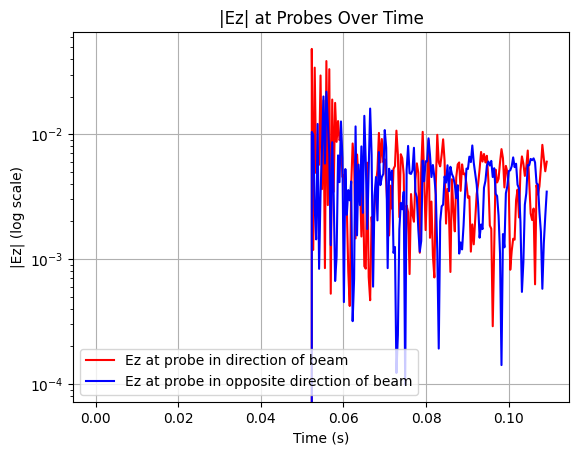

In [60]:
# Plot Ez at the probe in direction of beam over time in comparison to probe at opposite direction
time_steps = np.arange(max_time_steps)*magic_time_step
plt.semilogy(time_steps, Ez_probe_beam, label='Ez at probe in direction of beam', color = 'red')
plt.semilogy(time_steps, Ez_probe, label='Ez at probe in opposite direction of beam', color = 'blue')
plt.xlabel('Time (s)')
plt.ylabel('|Ez| (log scale)')
plt.title('|Ez| at Probes Over Time')
plt.legend()
plt.grid(True)
plt.show()

Originals  [-0.02442924+0.j         -0.02407645-0.0028723j  -0.0259442 -0.00556025j
 -0.02700953-0.00705539j -0.02728359-0.00926986j -0.0262981 -0.0157365j
 -0.03629071-0.02742487j -0.050354  -0.01920636j -0.02527274-0.02553991j
 -0.05446834-0.12120509j] corrected  [-0.02442924+0.j         -0.02410432-0.00262816j -0.02605156-0.0050333j
 -0.02721152-0.00623109j -0.02763685-0.00815657j -0.02706139-0.01438433j
 -0.03789018-0.02516889j -0.0515887 -0.01558897j -0.02725807-0.02340932j
 -0.06528144-0.11574026j]


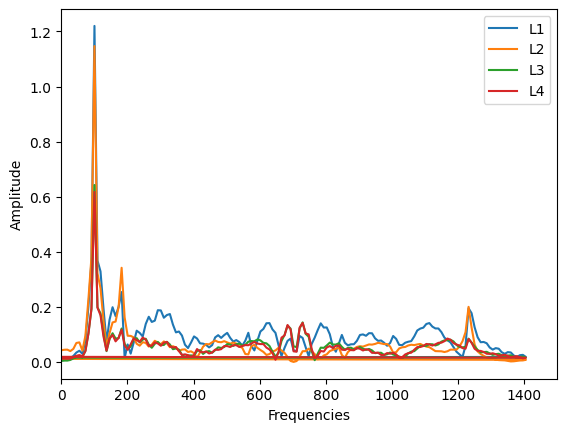

[Ez_fft_vals[0]] Max amplitude at corresponding frequency = -100.364 Hz
[Ez_fft_vals[1]] Max amplitude at corresponding frequency = -100.364 Hz
[Ez_fft_vals[2]] Max amplitude at corresponding frequency = 100.364 Hz
[Ez_fft_vals[3]] Max amplitude at corresponding frequency = 100.364 Hz
max_freqs_dict =  {'Ez_fft_vals[0]': np.float64(-100.36354313615513), 'Ez_fft_vals[1]': np.float64(-100.36354313615513), 'Ez_fft_vals[2]': np.float64(100.36354313615513), 'Ez_fft_vals[3]': np.float64(100.36354313615513)}
First frequency value: -100.36354313615513
Second frequency value: -100.36354313615513
Bin 1 index is  11
Bin 2 index is  11


In [90]:
#Performing FFT along closed contours
Ez_t_list = [Ez_time_L1, Ez_time_L2, Ez_time_L3, Ez_time_L4]

Ez_fft_vals = [np.fft.fft(Ez_time, axis=1) for Ez_time in Ez_t_list]
Ez_fft_vals_orig=Ez_fft_vals
Ez_freqs = [np.fft.fftfreq(max_time_steps, d=magic_time_step) for _ in Ez_t_list]

#applying temporal offset to Ez_fft_vals:
Ez_fft_vals_corrected = []
Nt=max_time_steps

for i in range(len(Ez_fft_vals)):
    Ez_fft = Ez_fft_vals[i]              # shape: [num_points, num_freqs]
    freqs = Ez_freqs[i]                  # shape: [num_freqs]
    #k goes from 1 to Nt
    k_vals = np.arange(Nt)
    
    phase_shift = np.exp(-1j * np.pi * k_vals / Nt)

    # Apply correction to each point's FFT
    Ez_fft_corrected = Ez_fft * phase_shift#[np.newaxis, :]  # broadcast across rows
    Ez_fft_vals_corrected.append(Ez_fft_corrected)

print('Originals ',Ez_fft_vals_orig[0][0][0:10],"corrected ",Ez_fft_vals_corrected[0][0][0:10])
Ez_fft_vals=Ez_fft_vals_corrected

Hx_t_list = [Hx_time_L1, Hx_time_L2, Hx_time_L3, Hx_time_L4]
Hx_fft_vals = [np.fft.fft(Hx_time, axis=1) for Hx_time in Hx_t_list]
Hx_freqs = [np.fft.fftfreq(max_time_steps, d=magic_time_step) for _ in Hx_t_list]

Hy_t_list = [Hy_time_L1, Hy_time_L2, Hy_time_L3, Hy_time_L4]

Hy_fft_vals = [np.fft.fft(Hy_time, axis=1) for Hy_time in Hy_t_list]
Hy_freqs = [np.fft.fftfreq(max_time_steps, d=magic_time_step) for _ in Hy_t_list]


#peak_freq_val=16.970562748477143

#sample plotting to find max frequency
plt.plot(Ez_freqs[0],abs(Ez_fft_vals[0][80]),label='L1')
plt.plot(Ez_freqs[1],abs(Ez_fft_vals[1][80]),label='L2')
plt.plot(Ez_freqs[2],abs(Ez_fft_vals[2][80]),label='L3')
plt.plot(Ez_freqs[3],abs(Ez_fft_vals[3][80]),label='L4')
plt.xlim([0,1500])
plt.legend()
plt.xlabel('Frequencies')
plt.ylabel('Amplitude')
plt.show()

'''
plt.figure()
plt.plot(Hx_freqs[0],abs(Hx_fft_vals[0][80]),label='L1')
plt.plot(Hx_freqs[1],abs(Hx_fft_vals[1][80]),label='L2')
plt.plot(Hx_freqs[2],abs(Hx_fft_vals[2][80]),label='L3')
plt.plot(Hx_freqs[3],abs(Hx_fft_vals[3][80]),label='L4')
plt.xlim([0,1500])
plt.legend()
plt.xlabel('Frequencies')
plt.ylabel('Amplitude')
plt.show()

plt.figure()
plt.plot(Hy_freqs[0],abs(Hy_fft_vals[0][80]),label='L1')
plt.plot(Hy_freqs[1],abs(Hy_fft_vals[1][80]),label='L2')
plt.plot(Hy_freqs[2],abs(Hy_fft_vals[2][80]),label='L3')
plt.plot(Hy_freqs[3],abs(Hy_fft_vals[3][80]),label='L4')
plt.xlim([0,1500])
plt.legend()
plt.xlabel('Frequencies')
plt.ylabel('Amplitude')
plt.show()
'''

#Computing equivalent J and M current densities
max_freqs_dict = {}
for i, fft_val in enumerate(Ez_fft_vals):
    freqs_arr = Ez_freqs[i]
    amp_spectrum = np.abs(fft_val)
    max_idx = np.unravel_index(np.argmax(amp_spectrum), amp_spectrum.shape)
    freq_at_max = freqs_arr[max_idx[1]]
    max_freqs_dict[f"Ez_fft_vals[{i}]"] = freq_at_max
    print(f"[Ez_fft_vals[{i}]] Max amplitude at corresponding frequency = {freq_at_max:.3f} Hz")

print('max_freqs_dict = ',max_freqs_dict)
#print('Target freq is ',target_freq)
first_freq = list(max_freqs_dict.values())[0]
second_freq=list(max_freqs_dict.values())[1]
print("First frequency value:", first_freq)
print("Second frequency value:", second_freq)
max_freq_val_L1_L3=first_freq
max_freq_val_L2_L4=second_freq


target_freq=f0
bin_idx_L1_L3 = np.argmin(np.abs(Ez_freqs[0] - target_freq))
print('Bin 1 index is ',bin_idx_L1_L3)
target_freq=f0
bin_idx_L2_L4 = np.argmin(np.abs(Ez_freqs[1] - target_freq))
print('Bin 2 index is ',bin_idx_L2_L4)


Meq_L1_phasors = Ez_fft_vals[0][:,bin_idx_L1_L3]
Meq_L2_phasors = -Ez_fft_vals[1][:,bin_idx_L2_L4]
Meq_L3_phasors = -Ez_fft_vals[2][:,bin_idx_L1_L3]
Meq_L4_phasors= Ez_fft_vals[3][:,bin_idx_L2_L4]

Jeq_L1_phasors=Hy_fft_vals[0][:,bin_idx_L1_L3]
Jeq_L2_phasors=-Hy_fft_vals[1][:,bin_idx_L2_L4]
Jeq_L3_phasors=-Hx_fft_vals[2][:,bin_idx_L1_L3]
Jeq_L4_phasors=Hx_fft_vals[3][:,bin_idx_L2_L4]

#creating list for all Jeq and Meq components along grid
Meq_phasors=[Meq_L1_phasors,Meq_L2_phasors,Meq_L3_phasors,Meq_L4_phasors]
Jeq_phasors=[Jeq_L1_phasors,Jeq_L2_phasors,Jeq_L3_phasors,Jeq_L4_phasors]


#Loading data from ntff_final
import pickle

# Load the phasors
with open('phasors_data.pkl', 'rb') as f:
    data = pickle.load(f)

#Meq_phasors = data['Meq_phasors']
#Jeq_phasors = data['Jeq_phasors']


In [84]:
#Computing r' cos (phi) for each exponential factor in scattering width eqn

#Nested loop to compute each individual line integral component, for each theta

#Computing scattering width for each theta component

theta_input_param=np.linspace(1,360,360)

r_prime_cos_phi_vec=[]
sigma_2d=np.zeros(360)

#replace lambda0 with lambda
#lambda_new=c0/peak_freq_val
max_freq_val_L1_L3=f0
max_freq_val_L2_L4=f0

lambda_L1_L3=1/max_freq_val_L1_L3
lambda_L2_4=1/max_freq_val_L2_L4
k_L1_L3 = 2 * np.pi / lambda_L1_L3
k_L2_L4=2*np.pi / lambda_L2_4
k_list=[k_L1_L3, k_L2_L4,k_L1_L3,k_L2_L4]
k_val_new=2*np.pi /lambda0
k_list=[k_val_new]
E_initial_amplitude = 1
for theta in theta_input_param:
    theta_deg = theta
    r_prime_cos_phi_vec_L1=[]
    r_prime_vec_L1=[]
    phi_vector_L1=[]

    theta_rad=math.radians(theta_deg)
    r_mag_L1=((L_ending_cell_idx-center_x)*dx) / math.cos(theta_rad)
    for x, y in L1_idxs:
        x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
        r_prime_mag=np.linalg.norm(x_y_distances)
        
        theta_prime_rad = math.asin ( ((y-center_y)*dy) / r_prime_mag)
        theta_prime_deg=math.degrees(theta_prime_rad)
        phi=theta_deg-theta_prime_deg

        phi_rad=math.radians(phi)
        phi_vector_L1.append(phi)

        phase_const= r_mag_L1 * math.cos(phi_rad)

        r_prime_cos_phi_vec_L1.append(phase_const)
    
    r_prime_cos_phi_vec_L2=[]
    r_prime_vec_L2=[]
    phi_vector_L2=[]
    r_mag_L2=abs(((L_starting_cell_idx-center_x)*dx)) / math.cos(theta_rad)

    for x, y in L2_idxs:
        x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
        r_prime_mag=abs(np.linalg.norm(x_y_distances))
        
        theta_prime_rad = math.asin ( ((y-center_y)*dy) / r_prime_mag)
        theta_prime_deg=math.degrees(theta_prime_rad)
        phi=-((theta_deg-180)-theta_prime_deg)

        phi_rad=math.radians(phi)
        phi_vector_L2.append(phi)

        phase_const= r_mag_L2 * math.cos(phi_rad)

        r_prime_cos_phi_vec_L2.append(phase_const)

    r_prime_cos_phi_vec_L3=[]
    r_prime_vec_L3=[]
    phi_vector_L3=[]
    r_mag_L3=abs(((L_ending_cell_idx-center_y*dy) / math.sin(theta_rad)))

    for x, y in L3_idxs:
        x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
        r_prime_mag=abs(np.linalg.norm(x_y_distances))
        
        theta_prime_rad = math.acos ( ((x-center_x)*dx) / r_prime_mag)
        theta_prime_deg=math.degrees(theta_prime_rad)
        phi=(180-theta_deg)-theta_prime_deg

        phi_rad=math.radians(phi)
        phi_vector_L3.append(phi)

        phase_const= r_mag_L3 * math.cos(phi_rad)

        r_prime_cos_phi_vec_L3.append(phase_const)

   
    r_prime_cos_phi_vec_L4=[]
    r_prime_vec_L4=[]
    phi_vector_L4=[]
    r_mag_L4=abs(((L_starting_cell_idx-center_y*dy) / math.sin(theta_rad)))

    for x, y in L4_idxs:
        x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
        r_prime_mag=abs(np.linalg.norm(x_y_distances))
        
        theta_prime_rad = math.acos ( ((x-center_x)*dx) / r_prime_mag)
        theta_prime_deg=math.degrees(theta_prime_rad)
        phi=-((theta_deg-180)-theta_prime_deg)

        phi_rad=math.radians(phi)
        phi_vector_L4.append(phi)

        phase_const= r_mag_L4 * math.cos(phi_rad)

        r_prime_cos_phi_vec_L4.append(phase_const)

    r_cos_factors=[r_prime_cos_phi_vec_L1,r_prime_cos_phi_vec_L2,r_prime_cos_phi_vec_L3,r_prime_cos_phi_vec_L4]
    r_cos_factors=np.array(r_cos_factors)

#want to check if getting same plot when only considering L1

    L_integral_arr=[ ((omega0*mu0*(Jeq[0:-1])) - (k_list_vals*(Meq[0:-1])))*np.exp(1j*k_list_vals*r_cos[0:-1])
                for Jeq, Meq, r_cos, k_list_vals in zip(Jeq_phasors,Meq_phasors, r_cos_factors,k_list)]
    k=2*np.pi/lambda0
    #L_integral_arr= ((omega0*mu0*(Jeq_phasors[2][0:-1])) - (k*(Meq_phasors[2][0:-1])))*np.exp(1j*k*r_cos_factors[2][0:-1])
                #for Jeq, Meq, r_cos in zip(Jeq_phasors,Meq_phasors, r_cos_factors)]
   
    #L_integral_vals=[ (np.sum(contour_val)) for contour_val in L_integral_arr]
    L_integral_vals= (np.sum(contour_val) for contour_val in L_integral_arr)

    L_integral_final=(abs(np.sum(L_integral_vals)))**2
    if(theta<90 or (theta>180 and theta <270)):
        lambda_val=lambda_L1_L3
    else:
        lambda_val=lambda_L2_4
    #lambda_val=1/peak_freq_val
    sigma_2d[int(theta) - 1]=L_integral_final* (lambda_val / (8*np.pi*(E_initial_amplitude**2)))  



C:\Users\Admin\AppData\Local\Temp\ipykernel_24028\424643413.py:123: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  L_integral_final=(abs(np.sum(L_integral_vals)))**2


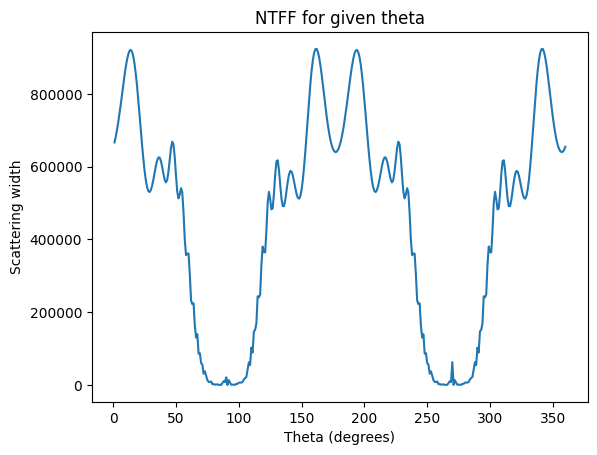

In [86]:
#Plotting Scattering width

 
plt.figure()
plt.plot(theta_input_param, sigma_2d)
plt.xlabel('Theta (degrees)')
plt.ylabel('Scattering width')
plt.title('NTFF for given theta')
plt.show()

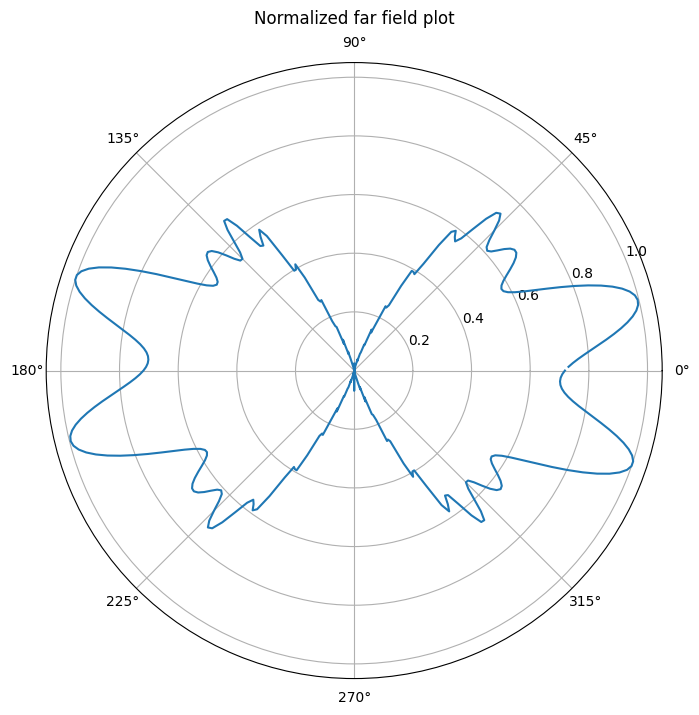

In [64]:
# Polar plot
# thetas = np.linspace(-90, 90, numY_cells)
theta_rad = np.radians(theta_input_param) # theta already in degrees
r_normalized = np.abs(sigma_2d)/np.max(np.abs(sigma_2d))

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
ax.plot(theta_rad, r_normalized)
# ax.set_theta_zero_location('right')  # 0 degrees points to the right
# ax.set_theta_direction(-1)           # Clockwise
ax.set_title('Normalized far field plot', va='bottom')
plt.show()